## Mercator projection of cell surface

In [ ]:
from skimage import data, morphology
import napari
import napari_shape_odyssey as nso
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import napari_process_points_and_surfaces as nppas
from napari_threedee.visualization.lighting_control import LightingControl

import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
import numpy as np
import tqdm
import os
import pandas as pd
from sklearn.decomposition import PCA
import copy

In [2]:
viewer = napari.Viewer(ndisplay=3)

Invalid schema for package 'napari-stl-exporter', please run 'npe2 validate napari-stl-exporter' to check for manifest errors.


## Segmentation

In [3]:
image = data.cells3d()
nuclei = image[:, 1]
membranes = image[:, 0]

segmentation = nsbatwm.voronoi_otsu_labeling(nuclei, 10, 2)
segmentation = np.asarray(cle.dilate_labels(segmentation, None, radius=1))
segmentation = morphology.area_closing(segmentation, 100, connectivity=1)

# turn pixels at edge of segmentation to zero with numpy
segmentation[0, :, :] = 0
segmentation[-1, :, :] = 0
segmentation[:, 0, :] = 0
segmentation[:, -1, :] = 0
segmentation[:, :, 0] = 0
segmentation[:, :, -1] = 0

In [4]:
viewer.add_image(nuclei, name='nuclei', colormap='bop blue', blending='additive')
viewer.add_image(membranes, name='membranes', colormap='bop orange', blending='additive')
viewer.add_labels(segmentation, name='segmentation', opacity=0.5)

<Labels layer 'segmentation' at 0x1b43ca8a820>

## Surface conversion

In [5]:
label_1 = 23
label_2 = 2
label_3 = 14
label_4 = 18

In [6]:
surface_1 = nppas.label_to_surface(segmentation, label_1)
surface_2 = nppas.label_to_surface(segmentation, label_2)
surface_3 = nppas.label_to_surface(segmentation, label_3)
surface_4 = nppas.label_to_surface(segmentation, label_4)

surface_1_smooth = nppas.remove_duplicate_vertices(nppas.smooth_surface(surface_1))
surface_2_smooth = nppas.remove_duplicate_vertices(nppas.smooth_surface(surface_2))
surface_3_smooth = nppas.remove_duplicate_vertices(nppas.smooth_surface(surface_3))
surface_4_smooth = nppas.remove_duplicate_vertices(nppas.smooth_surface(surface_4))

viewer.add_surface(surface_1_smooth, name='surface_1')
viewer.add_surface(surface_2_smooth, name='surface_2')
viewer.add_surface(surface_3_smooth, name='surface_3')
viewer.add_surface(surface_4_smooth, name='surface_4')

<Surface layer 'surface_4' at 0x1b43d942c10>

In [7]:
times = np.linspace(0, 2500, 50)
signature = nso.signatures.heat_kernel_signature(surface_1_smooth, times = times)
df = pd.DataFrame(signature, columns = [f'time_{i}' for i in range(signature.shape[1])])
viewer.layers['surface_1'].features = df

In [8]:
reducer = PCA(n_components=2)
reduced = reducer.fit_transform(signature[:, 1:20])

surface = list(viewer.layers['surface_1'].data)
surface[2] = reduced[:, 0]*10e5
viewer.layers['surface_1'].data = tuple(surface)

In [30]:
sphere = nso.unwrapping.map_surface_to_sphere(surface)
layer = viewer.add_surface(sphere, name='sphere', colormap='inferno')
layer.wireframe.visible = True

In [10]:
projected_map = nso.unwrapping.mercator_projection(sphere, width=256, height=128)

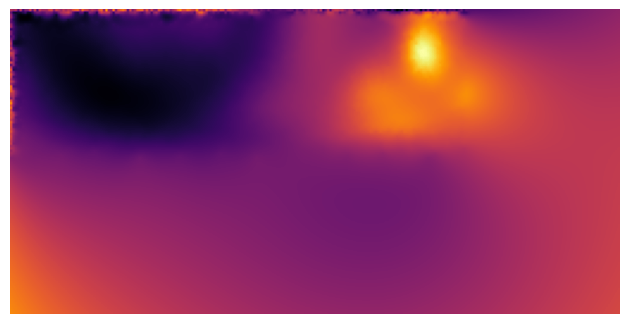

In [40]:
fig, ax = plt.subplots()
ax.imshow(projected_map, cmap='inferno')
ax.axis('off')
fig.tight_layout()
fig.savefig('./images/mercator_projection.png', dpi=300)

In [42]:
viewer.layers['surface_1'].contrast_limits = (-80, 90)

In [ ]:
vedo.g